<a href="https://colab.research.google.com/github/antoniogonzalezai/X-ray-dental-reconstruction-algorithm/blob/main/Panoramic_Dental_X_Ray_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

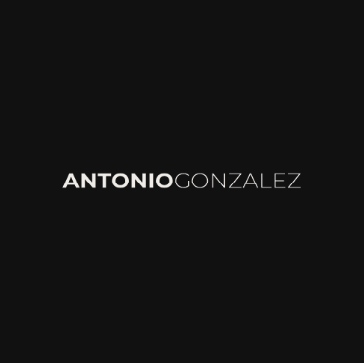


##**AutoEncoder**

*An autoencoder is a special type of neural network that is trained to copy its input to its output. Learns to compress the data while minimizing the reconstruction error.*


##**About dataset**

*his dataset consists of anonymized and deidentified panoramic dental X-rays of 116 patients, taken at Noor Medical Imaging Center, Qom, Iran. The subjects cover a wide range of dental conditions from healthy, to partial and complete edentulous cases. The mandibles of all cases are manually segmented by two dentists. This dataset is used as the basis for the article by Abdi et al*


*Data source:*

Abdi, Amir; Kasaei, Shohreh (2020), “Panoramic Dental X-rays With Segmented Mandibles”, Mendeley Data, V2, doi: 10.17632/hxt48yk462.2

## **Download Dataset from google storage**

Run the cell in order and follow steps

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!curl https://sdk.cloud.google.com | bash

In [ ]:
!gsutil cp gs://neurasys-datasets/Dental_Panaromic_Xrays/Dental-Panaromic-Autoencoder.npz .

##**Import Libraries**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import os
from tensorflow.keras.models import Sequential

##**Load dataset**

In [ ]:
from numpy import *
x = np.load('/content/Dental-Panaromic-Autoencoder.npz')
print(x.files)

['x_train', 'y_train', 'x_test', 'y_test']


## **Extrac Arrays From Dataset**

In [ ]:
x_train = x['x_train']
x_test = x['x_test']

##**Add noise** 

*We will train an automatic encoder to remove noise from images. A noisy version of the data set will be created by applying random noise to each image.*

In [ ]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

##**View images**

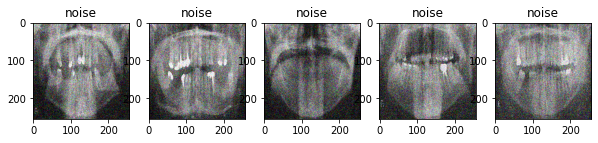

In [ ]:
n = 5
plt.figure(figsize=(10, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("noise")
    plt.imshow(tf.squeeze(x_train_noisy[i]))
    plt.gray()
plt.show()

##**Convolutional Encoder**

*We will train an automatic encoder using the noisy image as the input and the original image as the destination.
The imagnes are shaped 265x256 in RGB scale*

In [ ]:
input_shape = (256,256,3)

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=input_shape),
      layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

##**Plot both noisy images and images without noise produced by the auto encoder.**

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

##**View the results**

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):



    ax = plt.subplot(2, n, i + 1)
    plt.title("noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()